### Transfer Learning

Autoren: Hannes Bornemann, Michelle Winkle

In diesem Notebook wird gezeigt, wie Transfer Learning genutzt werden kann um Gemüse zu klassifizieren.


In [2]:
import os 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pandas as pd 

# setzen der Bildgröße für InceptionV3
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_CHANNELS=3

# setzen der Bildanzahl, nach der das Modell die Gewichte anpasst
batch_size = 20

In [3]:
# Pfade zu den Ordnern
folder_potato = 'photos_reduced/Kartoffel_reduced'
folder_onion = 'photos_reduced/Zwiebel_reduced'
folder_carrot = 'photos_reduced/Karotte_reduced'

# Initialisierung der Listen
categories = []
filenames = []

# Durchlaufen des Kartoffel-Ordners
for filename in os.listdir(folder_potato):
    categories.append(0)  # Kartoffel-Kategorie
    filenames.append(os.path.join(folder_potato, filename))

# Durchlaufen des Zwiebel-Ordners
for filename in os.listdir(folder_onion):
    categories.append(1)  # Zwiebel-Kategorie
    filenames.append(os.path.join(folder_onion, filename))

# Durchlaufen des Karotte-Ordners
for filename in os.listdir(folder_carrot):
    categories.append(2)  # Karotte-Kategorie
    filenames.append(os.path.join(folder_carrot, filename))

# Erstellung des DataFrames
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Ersetzen der Integer Werte für die Klasse durch strings 
df["category"] = df["category"].replace({0: 'potato', 1: 'onion', 2: 'carrot'}) 

# Teilen der Daten in Traingsdaten und Validierungsdaten
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_number = len(train_df)
validate_number = len(validate_df)
print ('Anzahl der Bilder (Train):',train_number)
print ('Anzahl der Bilder (Validate):',validate_number)

Anzahl der Bilder (Train): 2646
Anzahl der Bilder (Validate): 662


In [4]:
from tensorflow.keras import layers
from tensorflow.keras import models 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers

# Erstellung des Modells
model = models.Sequential()
# definieren des Basis-Modells 
base_model = InceptionV3(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
# hinzufügen des InceptionV3 Netzes zum Modell 
model.add(base_model)

# definieren des Prädikationsblock 
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax')) # 3 Klassen: Zwiebel, Karotte, Kartoffel
# deaktivieren des Training des Basis Modells 
base_model.trainable = False 
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 35043363 (133.68 MB)
Trainable params: 13240579 (50.51 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [5]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(1e-4),metrics=['acc'])

### Vorbereiten der Daten


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescalen und Data Augmentation für Trainingsdaten 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )
# rescalen der Testdaten 
test_datagen = ImageDataGenerator(
    rescale = 1./255
    )

# laden der Bilder über den ImageDataGenerator 
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = batch_size,
    class_mode = 'categorical' 
)

test_generator = test_datagen.flow_from_dataframe(
    validate_df,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = batch_size,
    class_mode = 'categorical' 
)

Found 2646 validated image filenames belonging to 3 classes.
Found 662 validated image filenames belonging to 3 classes.


### Trainieren des Netzes


In [7]:
history = model.fit(train_generator,
steps_per_epoch=100,
epochs = 5, #40
validation_data = test_generator,
validation_steps=validate_number//batch_size)

Epoch 1/5


100/100 [==============================] - 107s 1s/step - loss: 0.1937 - acc: 0.9110 - val_loss: 0.0336 - val_acc: 0.9864
Epoch 2/5
100/100 [==============================] - 98s 975ms/step - loss: 0.0552 - acc: 0.9743 - val_loss: 0.0624 - val_acc: 0.9712
Epoch 3/5
100/100 [==============================] - 101s 1s/step - loss: 0.0400 - acc: 0.9794 - val_loss: 0.0307 - val_acc: 0.9848
Epoch 4/5
100/100 [==============================] - 101s 1s/step - loss: 0.0386 - acc: 0.9789 - val_loss: 0.0235 - val_acc: 0.9879
Epoch 5/5
100/100 [==============================] - 98s 984ms/step - loss: 0.0402 - acc: 0.9778 - val_loss: 0.0165 - val_acc: 0.9879


In [8]:
# Das Modell kann zum Vergleichen von unterschiedlichen Parametern des Prädikationsblocks abgespeichert werden
# model.save('cats_dogs_1.h5')

### Auswerten des Netzes


In [9]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

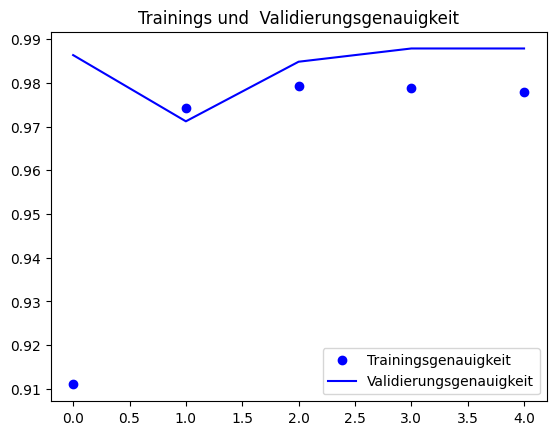

<Figure size 640x480 with 0 Axes>

In [10]:
plt.plot(epochs,acc,'bo',label='Trainingsgenauigkeit')
plt.plot(epochs,val_acc,'b',label='Validierungsgenauigkeit')
plt.title('Trainings und  Validierungsgenauigkeit')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

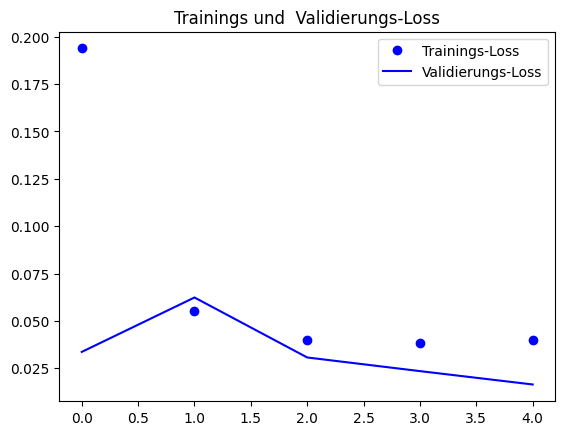

<Figure size 640x480 with 0 Axes>

In [11]:
plt.plot(epochs,loss,'bo',label='Trainings-Loss')
plt.plot(epochs,val_loss,'b',label='Validierungs-Loss')
plt.title('Trainings und  Validierungs-Loss')
plt.legend()
plt.figure()